In [231]:
import numpy as np
from uncertainties import ufloat, unumpy
from uncertainties.umath import *
from astropy.io import fits
from astropy.table import Table
import pandas
import matplotlib.pyplot as plt
from astropy.stats import LombScargle
from scipy.ndimage.filters import gaussian_filter
from scipy import signal
from importlib import reload as reload
import warnings
warnings.filterwarnings("ignore")

In [232]:
import astropy.visualization.hist as bhist

In [233]:
import pulsations as p

# Import Evt and Exposure Time Files
- for epoch 1 and 3 of nicer data

In [234]:
e1path = 'NIC_3ep/epoch1/'
# e2path = 'NIC_3ep/epoch2/'
e3path = 'NIC_3ep/epoch3/'
#tables of start and end times from each epoch
tep1 = p.readevt(e1path+'epoch1-sun80-spaceweather_bar.evt',ind=2)
# tep1_nos = p.readevt(e1path+'epoch1-sun80.evt',ind=2)
# ep1_nos = p.readevt(e1path+'epoch1-sun80.evt')

# tep2 = p.readevt(e2path+'epoch2-sun80-spaceweather_bar.evt',ind=2)
tep3 = p.readevt(e3path+'epoch3-sun80-spaceweather_bar.evt',ind=2)
#corresponding event tables
ep1 = p.readevt(e1path+'epoch1-sun80-spaceweather_bar.evt')
# ep2 = p.readevt(e2path+'epoch2-sun80-spaceweather_bar.evt')
ep3 = p.readevt(e3path+'epoch3-sun80-spaceweather_bar.evt')

# Filter Tables for Soft and Hard X-rays

In [235]:
#filter to just have soft events in evt
e1s = ep1[ep1['PI']<=150]
e1s = e1s[e1s['PI']>=30]
#repeat for hard PI range
e1h = ep1[ep1['PI']>150]
e1h = e1h[e1h['PI']<800]

In [236]:
#repeat for epoch 3
e3s = ep3[ep3['PI']<=150]
e3s = e3s[e3s['PI']>=30]
e3h = ep3[ep3['PI']>150]
e3h = e3h[e3h['PI']<800]

# Bin by Exposure Time


In [237]:
def expbin(soft,hard,time,plot=False):
    '''Use exposure time intervals to bin soft and hard evt lists.'''
    tbins = np.concatenate((time['START'],time['STOP']))
    tbins = np.sort(tbins)
    shist = bhist(soft['TIME'],bins=tbins,histtype='step',color='maroon',alpha=.4)
    hhist = bhist(hard['TIME'],bins=tbins,histtype='step',color='navy',alpha=.4)
    if plot:
        plt.close()
        bin_wid = shist[1][1:]-shist[1][:-1]
        #total counts in each bin
        #average tim ein bin is first bound plus half the bin width 
        bint = shist[1][:-1]+(bin_wid/2)
        scounts = shist[0]
        hcounts = hhist[0]
        bint = bint[::2] 
        scounts = scounts[::2]
        hcounts = hcounts[::2]
        bin_wid = bin_wid[::2]
        hr = (hcounts-scounts)/(hcounts+scounts)
        cr = (scounts+hcounts)/bin_wid
        plt.scatter(hr,cr,color='black')
        return
    return shist,hhist

## first, let's see what happens if we bin by exposure time and don't bin further
- we know we don't want that ultimately, though, because the exposure times are often shorter than the spin period
- we want to get to binning of at least ~300 seconds

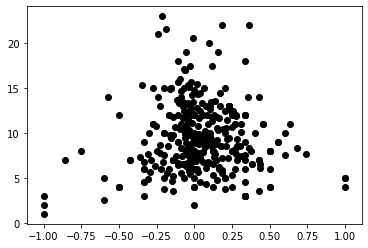

In [238]:
#first epoch
expbin(e1s,e1h,tep1,plot=True)

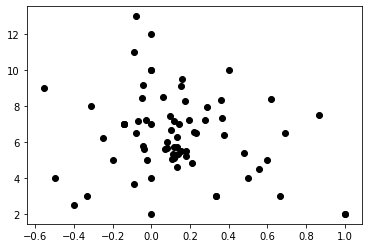

In [239]:
#second epoch
expbin(e3s,e3h,tep3,plot=True)

# Two Methods to Bin
- in both cases, I first bin by exposure time
- first method: divide those exposure bins into n bins
    - problem is, the exposure times vary
    - if we just want to achieve a minimum binning time, it's not a problem
    - two versions of this method: one only keeps bins that are divisible by this number, other keeps the remainder
- second method: set minimum exposure time; loops through exposure bins and stops making a new bin once that exposure time is reached

*notice the first method doesn't work super well since the exposure intervals vary so much. you can try out different values of n, but getting the minimum time in a bin low enough also requires very few bins*

In [240]:
def nbins(soft,hard,tep,n=20):
    '''Take output of expbin and bin further
    To do: use array_split which allows for splitting without equal division
           incorporate errors '''
#     plt.subplots(1,2,figsize=(10,4))
    shi, hhi = expbin(soft,hard,tep,sub=True)
    plt.close() #don't display histogram
    bin_wid = shi[1][1:]-shi[1][:-1]
    print(len(bin_wid))
    #total counts in each bin
    #average time in bin is first bound plus half the bin width 
    bint = shi[1][:-1]+(bin_wid/2)
    scounts = shi[0]
    hcounts = hhi[0]
    if len(bin_wid)%(2*n) == 0: 
        #adding dummy number to allow for indexing of end
        bin_wid = np.concatenate((bin_wid,[0]))
        scounts = np.concatenate((scounts,[0]))
        hcounts = np.concatenate((hcounts,[0]))
        end = -1
    else: end = -1*(len(bin_wid)%(2*n))
    print(end)
    #when you get to high n, separately sum those cut-off contributions
    #first reshape to get bin widths that correspond to zeros
    times = np.reshape(bint[:end],(np.int(len(bint[:end])/2),2))
    bnw = np.reshape(bin_wid[:end],(np.int(len(bin_wid[:end])/2),2))
    bnw2 = bnw[:,0] #only keeps widths during exposures
    times2 = times[:,0] 
    sco = np.reshape(scounts[:end],(np.int(len(scounts[:end])/(2*n)),2*n))
    hco = np.reshape(hcounts[:end],(np.int(len(hcounts[:end])/(2*n)),2*n))
    binw = np.reshape(bnw2,(np.int(len(bnw2)/n),n))
    tms = np.reshape(times2,(np.int(len(times2)/n),n))
    
    sco2 = np.sum(sco,axis=1)
    hco2 = np.sum(hco,axis=1)
    binw2 = np.sum(binw,axis=1)
    #find new average time
    tms2 = np.mean(tms,axis=1) #can add errorbars on time that show time interval used
    
    ghr = (hco2-sco2)/(hco2+sco2) #to do: add errors, repeat for bin times
    #count rate
    gtot = hco2+sco2
    gcr = gtot/binw2
    
    plt.scatter(ghr,gcr,c=binw2)
    plt.xlabel('HR')
    plt.ylabel('CR')
    plt.colorbar(label='Exposure Time (s)') #color as bin width or tot counts gives similar answer
    return ghr,gtot,gcr,tms2

In [241]:
def nbins2(soft,hard,tep,n=20,plot=True,expcolor=False):
    '''Take output of expbin and bin further. Same as nbins but uses array_split
    to keep bins in remainder of division by n '''
#     plt.subplots(1,2,figsize=(10,4))
    shi, hhi = expbin(soft,hard,tep)
    plt.close() #don't display histogram
    bin_wid = shi[1][1:]-shi[1][:-1]
    print(len(bin_wid))
    #total counts in each bin
    #average time in bin is first bound plus half the bin width 
    bint = shi[1][:-1]+(bin_wid/2)
    scounts = shi[0]
    hcounts = hhi[0]
    #keep every other element to get rid of bins with no exposure
    bint = bint[::2] 
    scounts = scounts[::2]
    hcounts = hcounts[::2]
    bin_wid = bin_wid[::2]
    
    #split each array into n groups
    sco = np.array_split(scounts,n)
    hco = np.array_split(hcounts,n)
    binw = np.array_split(bin_wid,n)
    tms = np.array_split(bint,n)
    
    #loop thru lists of arrays and sum
    #more efficient version could add zeros, stack arrays in list, and sum along correct axis
    sbin = np.zeros(len(sco))
    hbin = np.zeros(len(sco))
    bwb = np.zeros(len(sco))
    tbin = np.zeros(len(sco))
    tlow = np.zeros(len(sco))
    thi = np.zeros(len(sco))
    for i in range(len(sco)):
        sbin[i] = np.sum(sco[i])
        hbin[i] = np.sum(hco[i])
        bwb[i] = np.sum(binw[i])
        #mean time within bin adopted as time for bin
        tbin[i] = np.mean(tms[i])
        tlow[i] = np.min(tms[i])
        thi[i] = np.max(tms[i])

        
    #using square root of counts for error
    serr=unumpy.uarray(sbin,np.sqrt(sbin)) 
    herr=unumpy.uarray(hbin,np.sqrt(hbin))
    ghr = (hbin-sbin)/(hbin+sbin) #to do: add errors, repeat for bin times
    ratio = (herr-serr)/(herr+serr)
    terr = herr+serr
    #count rate
    gtot = hbin+sbin
    gcr = gtot/bwb
    gcrerr = terr/bwb
    rerr = np.zeros(len(ratio))
    crerr = np.zeros(len(ratio))

    for r in range(len(ratio)):
        rerr[r]=ratio[r].s #separates error 
        crerr[r]=gcrerr[r].s #separates error 
    #plot
    #add errors
    print('minimum bin exposure time: ',np.min(bwb))
    if plot:
        fig,ax = plt.subplots(3,1,figsize=(6,12))
        if expcolor: #show exposure time with color
            ax[0].scatter(ghr,gcr,c=bwb)
            ax[0].errorbar(ghr,gcr,yerr=crerr,xerr=rerr,linestyle='none',color='black',alpha=.2)       
        else: 
            ax[0].errorbar(ghr,gcr,yerr=crerr,xerr=rerr,linestyle='none',marker='o',color='black')       
        ax[0].set_xlabel('HR')
        ax[0].set_ylabel('CR')
        ax[1].set_ylabel('CR')
        ax[1].errorbar(tbin,gcr,yerr=crerr,xerr=(tbin-tlow,thi-tbin),linestyle='none',marker='o',color='black')
        ax[1].set_xlabel('Time')
        ax[2].set_xlabel('Time')
        ax[2].set_ylabel('HR')
        ax[2].errorbar(tbin,ghr,yerr=rerr,xerr=(tbin-tlow,thi-tbin),linestyle='none',marker='o',color='black')

#         fig.colorbar(label='Exposure Time (s)') #color as bin width or tot counts gives similar answer
    #tuples of value and error
    return (ghr,rerr),(gtot,np.sqrt(gtot)),(gcr,crerr),(tbin,tlow,thi)

713
minimum bin exposure time:  146.00061985850334


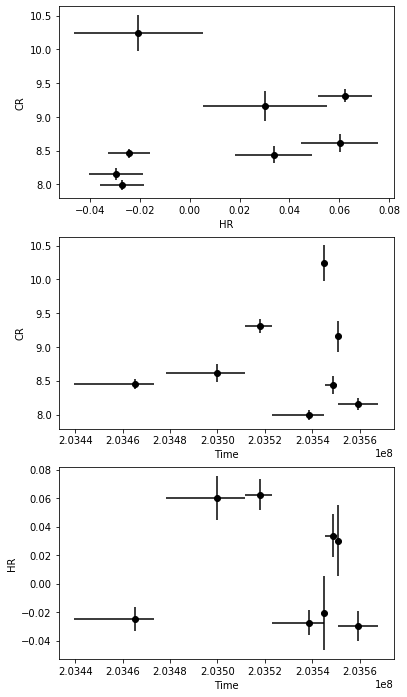

In [242]:
#set number of bins (data points)
n = 8
hr1,tot1,cr1,tb1 = nbins2(e1s,e1h,tep1,n=n)

145
minimum bin exposure time:  21.99987557530403


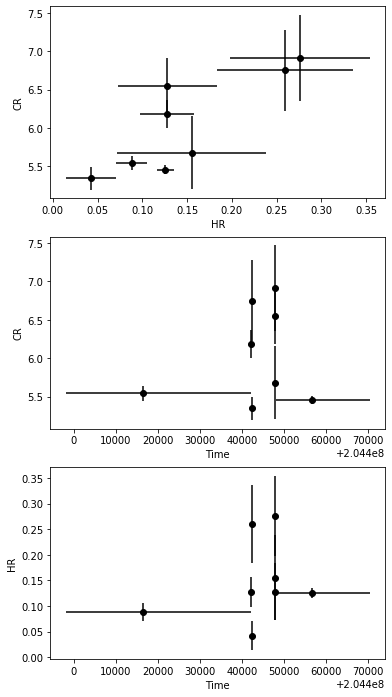

In [243]:
#set number of bins (data points)
n = 8
hr3,tot3,cr3,tb3 = nbins2(e3s,e3h,tep3,n=n)

## second method: stop creating bin once minimum exposure time reached

In [244]:
def adaptbin(soft,hard,tep,n=2,cut=300,plot3=False):
    '''Less efficient, but get minimum of 300 second exposure time in each bin
    To do: add mean times and use for plotting'''
    shi, hhi = expbin(soft,hard,tep)
    plt.close()
    bin_wid = shi[1][1:]-shi[1][:-1]
    #total counts in each bin
    #average tim ein bin is first bound plus half the bin width 
    bint = shi[1][:-1]+(bin_wid/2)
    scounts = shi[0]
    hcounts = hhi[0]
    
    ind = 0 #switch start ind once 300 s exposure achieved each time
    chinds = [] #inds to start summing at
    if len(bin_wid)%2==0:
        bnw = np.reshape(bin_wid,(np.int(len(bin_wid)/2),2))
        sco = np.reshape(scounts,(np.int(len(scounts)/(2)),2))
        hco = np.reshape(hcounts,(np.int(len(hcounts)/(2)),2))
        bnt = np.reshape(bint,(np.int(len(bint)/(2)),2))
    else:
        bnw = np.reshape(bin_wid[:-1],(np.int(len(bin_wid[:-1])/2),2))
        sco = np.reshape(scounts[:-1],(np.int(len(scounts[:-1])/(2)),2))
        hco = np.reshape(hcounts[:-1],(np.int(len(hcounts[:-1])/(2)),2))
        bnt = np.reshape(bint[:-1],(np.int(len(bint[:-1])/(2)),2))

    bw = bnw[:,0] #only keeps widths during exposures
    sco = sco[:,0]
    hco = hco[:,0]
    bt = bnt[:,0]
    sumt = 0
    expts = []
    #can change to do everything in one loop, but separated for now b/c of testing
    for i in range(len(bw)):
        sumt += bw[i]
        if sumt > cut:
            expts.append(sumt)
            sumt = 0 #reset to 0
            chinds.append(i+1)
    #soft subarrays
    ssubs = np.split(sco,chinds)
    hsubs = np.split(hco,chinds)
    bwsubs = np.split(bw,chinds)
    tsubs = np.split(bt,chinds)
    print(len(ssubs),len(tsubs))
    sbin = np.zeros(len(ssubs))
    hbin = np.zeros(len(ssubs))
    bwb = np.zeros(len(ssubs))
    tbin = np.zeros(len(ssubs))
    tlow = np.zeros(len(ssubs))
    thi = np.zeros(len(ssubs))
    for s in range(len(ssubs)):
        sbin[s]=np.sum(ssubs[s])
        hbin[s]=np.sum(hsubs[s])
        bwb[s]=np.sum(bwsubs[s])
        tbin[s]=np.mean(tsubs[s]) #take average time within interval
        tlow[s]=np.min(tsubs[s])
        thi[s]=np.max(tsubs[s])

    print(len(sbin),len(tbin))
    #version with error bars    
    serr=unumpy.uarray(sbin[:-1],np.sqrt(sbin[:-1])) #error is square root of counts
    herr=unumpy.uarray(hbin[:-1],np.sqrt(hbin[:-1]))
    ratio=(herr-serr)/(herr+serr)
           
    ghr = (hbin[:-1]-sbin[:-1])/(hbin[:-1]+sbin[:-1]) #to do: add errors, repeat for bin times
    #count rate
    gtot = hbin[:-1]+sbin[:-1]
    gterr = serr+herr
    gcr = gtot/bwb[:-1]
    gcrerr = gterr/bwb[:-1] #not sure of error on bin time
    #get errors on count rate and ratio
    rerr = np.zeros(len(serr))
    crerr = np.zeros(len(serr))
    for r in range(len(ratio)):
        rerr[r]=ratio[r].s #separates error 
        crerr[r]=gcrerr[r].s #separates error 
    if plot3:
        fig,ax = plt.subplots(3,1,figsize=(6,12))
        ax[0].errorbar(ghr,gcr,yerr=crerr,xerr=rerr,linestyle='none',marker='o',color='black')       
        ax[0].set_xlabel('HR')
        ax[0].set_ylabel('CR')
        ax[1].set_ylabel('CR')
        ax[1].errorbar(tbin[:-1],gcr,yerr=crerr,xerr=(tbin[:-1]-tlow[:-1],thi[:-1]-tbin[:-1]),linestyle='none',marker='o',color='black')
        ax[1].set_xlabel('Time')
        ax[2].set_xlabel('Time')
        ax[2].set_ylabel('HR')
        ax[2].errorbar(tbin[:-1],ghr,yerr=rerr,xerr=(tbin[:-1]-tlow[:-1],thi[:-1]-tbin[:-1]),linestyle='none',marker='o',color='black')
    else:
        plt.scatter(ghr,gcr,c=bwb[:-1])
        plt.errorbar(ghr,gcr,xerr=rerr,yerr=crerr,linestyle='none',alpha=.2,color='black')
        plt.xlabel('HR')
        plt.ylabel('CR')
        plt.colorbar(label='Exposure Time (s)') #color as bin width or tot counts gives similar answer
    return (ghr,rerr),(gtot,np.sqrt(gtot)),(gcr,crerr),(tbin[:-1],tlow[:-1],thi[:-1])

13 13
13 13


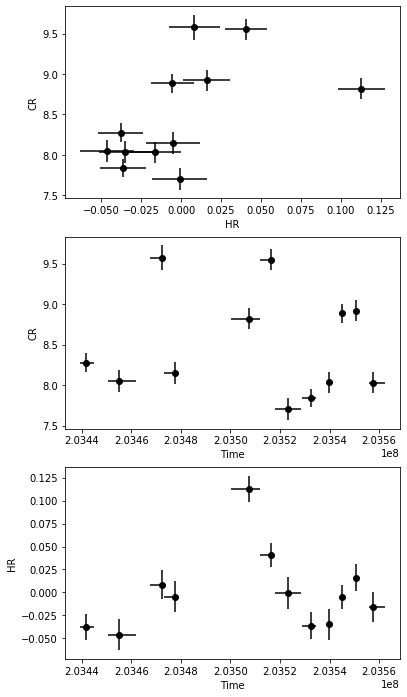

In [245]:
#cut is minimum exposure time
cut = 400
ghr1,gtot1,gcr1,tbin1 = adaptbin(e1s,e1h,tep1,cut=cut,plot3=True)


6 6
6 6


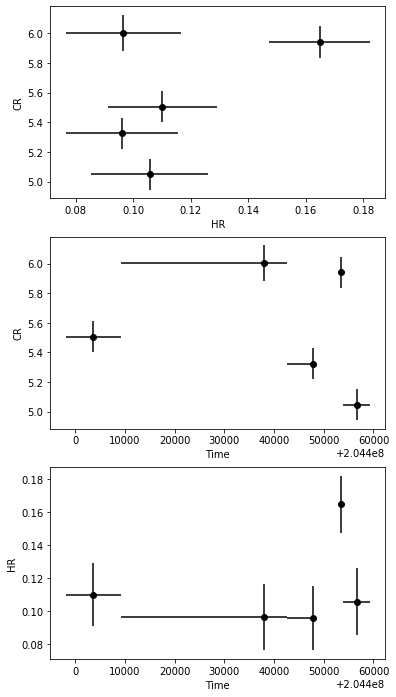

In [246]:
cut = 400
ghr3,gtot3,gcr3,tbin3 = adaptbin(e3s,e3h,tep3,cut=cut,plot3=True)

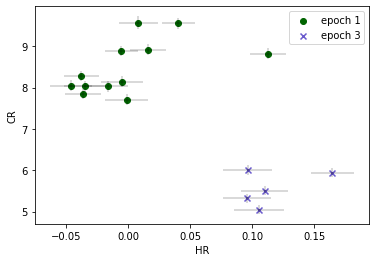

In [247]:
plt.scatter(ghr1[0],gcr1[0],color='darkgreen',label='epoch 1')
plt.scatter(ghr3[0],gcr3[0],color='slateblue',marker='x',label='epoch 3')
plt.errorbar(ghr1[0],gcr1[0],xerr=ghr1[1],yerr=gcr1[1],linestyle='none',alpha=.2,color='black')
plt.errorbar(ghr3[0],gcr3[0],xerr=ghr3[1],yerr=gcr3[1],linestyle='none',alpha=.2,color='black')

plt.legend()
plt.xlabel('HR')
plt.ylabel('CR')
plt.savefig('CRHR.png',dpi=200,bbox_inches='tight')
